In [1]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAE, VGAEOutput, decoder, PriorVAE
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
RNG_KEY = jax.random.PRNGKey(42)

In [3]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [4]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  decoder_params: Optional[Params] = None
  
CAR_ARGS = CARArgs()

In [5]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  # alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
  alpha = 0.7

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

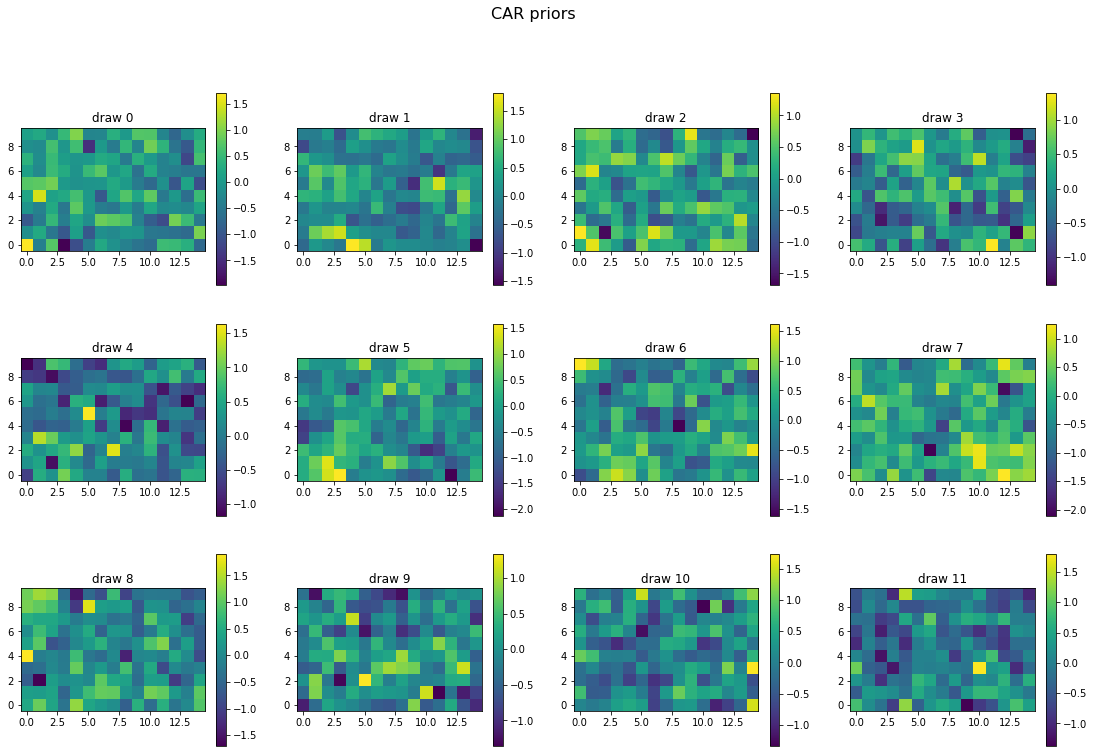

In [6]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=1000)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [7]:
SCALE = 1.0

def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return SCALE * car_draws

def generate_graph_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_draws = generate_car_batch(rng, batch_size, model_args)
    graphs = [
        dataset.get_car_draws_as_graph(draw.reshape(-1, 1), A) 
            for draw in car_draws
    ]
    return jraph.batch(graphs)

In [8]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  num_nodes: int = A.shape[0]  
  batch_size: int = 1  # saw 100 is better than 500.
  
  # hidden_dim: int = 20
  # latent_dim: int = 2
  hidden_dim: int = 20
  latent_dim: int = 2
  output_dim: int = 1
  
  learning_rate: float = 1e-4
  epochs: int = 500_000
  
  eval_frequency: int = 10_000
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x1375a0d30>, num_nodes=150, batch_size=1, hidden_dim=20, latent_dim=2, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class NoScaler:
    def __init__(self):
        return
    def fit(self, x):
        pass
    def fit_transform(self, x):
        return np.array(x)
    def transform(self, x):
        return np.array(x)
    def inverse_transform(self, x):
        return np.array(x)

In [10]:
RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)

train_data = generate_car_batch(train_rng, batch_size=ARGS.epochs)
val_data = generate_car_batch(val_rng, batch_size=ARGS.epochs)

In [11]:
scaler = NoScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

base_graph = dataset.create_grid_graph(A)
scaled_graph_train_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_train_data
]
scaled_graph_val_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_val_data
]

In [12]:
def rescale_nodes(nodes: jnp.ndarray):
    return scaler.inverse_transform(nodes.reshape(1, -1))

# # Unscaling process
# unscaled_train_data = [rescale_nodes(g.nodes) for g in scaled_graph_train_data]
# unscaled_val_data = [rescale_nodes(g.nodes) for g in scaled_graph_val_data]

In [13]:
from typing import Tuple

import layer

def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
        del edges
        x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
        return hk.Linear(1)(x)

def encoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        latent_dim: int,
        act_fn: Callable = jax.nn.leaky_relu
    ) -> Tuple[jraph.GraphsTuple, jraph.GraphsTuple]:

    gn = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Sequential([
            hk.Linear(hidden_dim), act_fn]),
    )
    graph = gn(graph)
    
    # No activation
    gn_mean = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(latent_dim),
    )
    gn_log_std = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(latent_dim),
    )
    
    mean_graph, log_std_graph = gn_mean(graph), gn_log_std(graph)
    return mean_graph, log_std_graph


def decoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        output_dim: int,
        act_fn: Callable = jax.nn.leaky_relu) -> jraph.GraphsTuple:
    
    gn = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Sequential([
            hk.Linear(hidden_dim, name='decoder_hidden'),
            act_fn]),
    )
    graph = gn(graph)
    
    # No activation
    gn = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(output_dim, name='decoder_output'),
    )
    graph = gn(graph)

    return graph


class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_dim,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean_graph, log_std_graph = encoder(
            graph,
            self._hidden_dim,
            self._latent_dim,
        )
        mean, log_std = mean_graph.nodes, log_std_graph.nodes
        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)
        z_graph = mean_graph._replace(nodes=z)
        output = decoder(
            z_graph,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, log_std, output)

In [14]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=ARGS.hidden_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim)(x))

optimizer = optax.adam(ARGS.learning_rate)

# scheduler = optax.exponential_decay(
#     init_value=ARGS.learning_rate,
#     transition_steps=1000,
#     decay_rate=0.99,
# )

# # Combining gradient transforms using `optax.chain`
# optimizer = optax.chain(
#     optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# )

In [15]:
from model import VGAEOutput

@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -10**2 * log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  
  return -elbo
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [16]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = scaled_graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [17]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)
  
  train_graph_batch = scaled_graph_train_data[epoch]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)

  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = scaled_graph_val_data[epoch]
    val_loss = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
      
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x1375a0d30>
00:36:07 STEP: 0; Train loss: 35.753; Validation loss: 31.369
00:36:11 STEP: 10000; Train loss: 16.267; Validation loss: 25.780
00:36:16 STEP: 20000; Train loss: 17.973; Validation loss: 16.940
00:36:21 STEP: 30000; Train loss: 19.130; Validation loss: 22.330
00:36:25 STEP: 40000; Train loss: 14.740; Validation loss: 15.027
00:36:30 STEP: 50000; Train loss: 15.189; Validation loss: 19.341
00:36:34 STEP: 60000; Train loss: 12.811; Validation loss: 15.813
00:36:39 STEP: 70000; Train loss: 14.673; Validation loss: 14.687
00:36:44 STEP: 80000; Train loss: 20.544; Validation loss: 13.020
00:36:48 STEP: 90000; Train loss: 13.600; Validation loss: 16.971
00:36:52 STEP: 100000; Train loss: 13.427; Validation loss: 15.706
00:36:57 STEP: 110000; Train loss: 18.943; Validation loss: 20.149
00:37:01 STEP: 120000; Train loss: 12.360; Validation loss: 14.369
00:37:06 STEP: 130000; Train loss: 16.344; Validation loss: 20.091
00:37:10 STEP: 140000; Tr

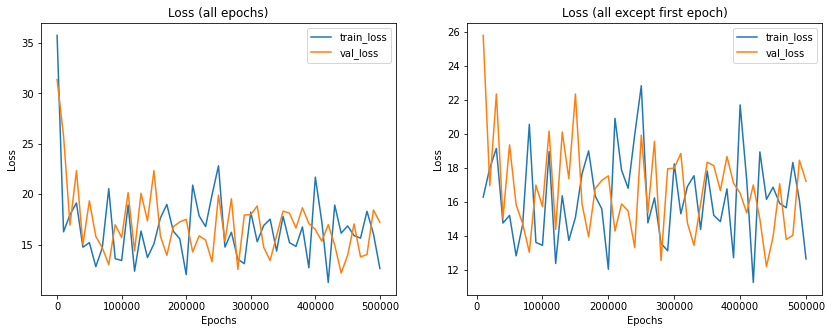

In [18]:
from matplotlib.ticker import MaxNLocator

_, axes = plt.subplots(1, 2, figsize=(14, 5))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0].plot(xs, train_losses, label='train_loss')
axes[0].plot(xs, val_losses, label='val_loss')
axes[1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0].set_title('Loss (all epochs)')
axes[1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
plt.show()

In [19]:
# # Unscaling process
# unscaled_train_data = [scaler.inverse_transform(g.nodes.reshape(1, -1)) for g in scaled_graph_train_data]
# unscaled_val_data = [scaler.inverse_transform(g.nodes.reshape(1, -1)) for g in scaled_graph_val_data]

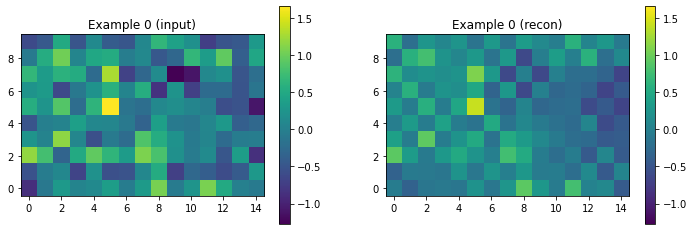

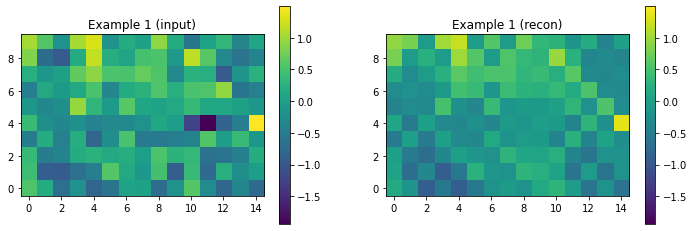

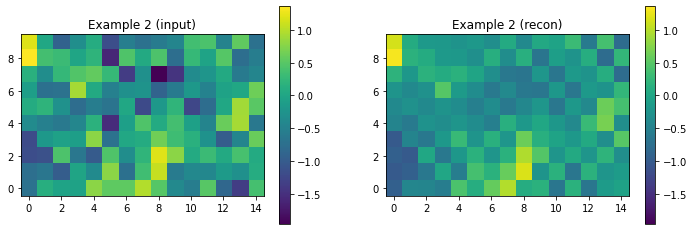

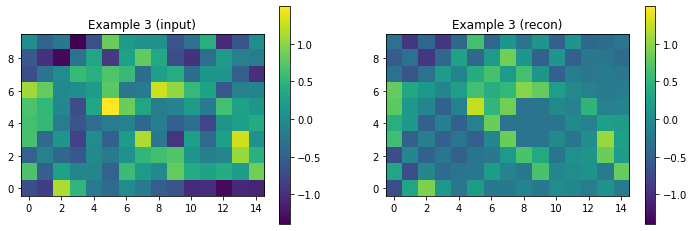

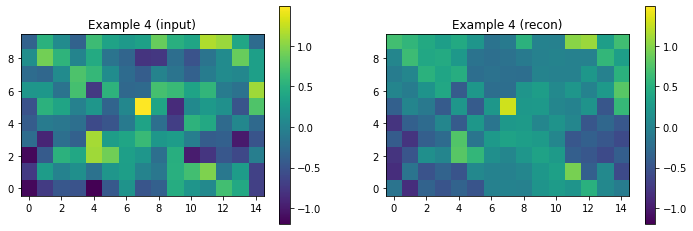

In [20]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    original_data = val_data[i]
    scaled_data_graph = scaled_graph_val_data[i]
    outputs = net.apply(params, RNG_KEY, scaled_data_graph)
    
    # Unscaling
    recon_data = rescale_nodes(outputs.output.nodes)

    original_image = jnp.ravel(original_data)
    recon_image = jnp.ravel(recon_data)

    ax = plotting.plot_images_from_arrays(
        arrays=[original_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')

WHAT I DID: 

- 30/7 00:32: Removed node_update_fn in first GAT layer
- 30/7 00:38: Removed 10**3 factor in loss function
- 30/7 12:52: Remove activation in the last encoder layers (mean, std)
- 30/7 12:57: Added self edges to all GAT layers (including no activation ones)
- 30/7 13:05: Added 10**2 factor in loss function (to see self edges + good learning)
- 30/7 13:14: Remove self edges from final GAT layers (in both encoder and decoder)
- 30/7 13:23: Remove self edges from all GAT layers; remove StandardScaler; remove 10**2 factor in loss.
- 30/7 13:49: Change learning rate 1e-4 -> 1e-2
- 30/7 13:55: Change learning rate 1e-2 -> 1e-3
- 30/7 14:02: Change learning rate -> 1e-1 but apply scheduler. (nan results)
- 30/7 15:04: Change learning rate -> 1e-2 but apply scheduler.